In [1]:
from pprint import pprint

In [2]:
from compert.train import train_compert, prepare_compert
from compert.data import load_dataset_splits, Dataset
from compert.plotting import CompertVisuals
from compert.api import ComPertAPI
from compert.model import ComPert
import pandas as pd
import scanpy as sc
import numpy as np
import torch
from sklearn.preprocessing import KBinsDiscretizer

In [3]:
adata = sc.read('kang_preprocessed_scores.h5ad')

In [4]:
adata.uns['terms'][73:76]

array(['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
       'REACTOME_INTERFERON_GAMMA_SIGNALING',
       'REACTOME_INTERFERON_SIGNALING'], dtype=object)

In [19]:
# normilize scores and select interferon related
mx = adata.obsm['scores'].max(0)
mn = adata.obsm['scores'].min(0)
adata.obsm['scores_tr'] = ((adata.obsm['scores']-mn)/(mx-mn))[:, 73:76]

In [12]:
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')

In [13]:
est.fit(adata.obsm['scores_tr'])

KBinsDiscretizer(encode='ordinal', n_bins=3)

In [ ]:
adata.write('kang_preprocessed_scores.h5ad')

In [119]:
adata.obs['INTERFERON_ALPHA_BETA_SIGNALING_SCORE'] = adata.obsm['scores_tr'][:, 0]
adata.obs['INTERFERON_GAMMA_SIGNALING_SCORE'] = adata.obsm['scores_tr'][:, 1]
adata.obs['INTERFERON_SIGNALING_SCORE'] = adata.obsm['scores_tr'][:, 2]

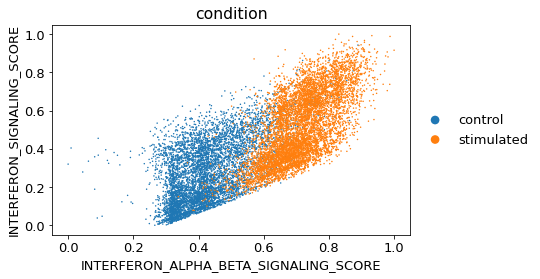

In [32]:
sc.pl.scatter(adata, x='INTERFERON_ALPHA_BETA_SIGNALING_SCORE', y='INTERFERON_SIGNALING_SCORE', color='condition')

In [14]:
args = {'dataset_path': './kang_preprocessed_scores.h5ad', # full path to the anndata dataset 
        'cell_type_key': None, # necessary field for cell types. Fill it with a dummy variable if no celltypes present.
        'split_key': 'split', # necessary field for train, test, ood splits.
        'perturbation_key': None, # necessary field for perturbations
        'dose_key': None, # necessary field for dose. Fill in with dummy variable if dose is the same. 
        'gene_sets_key': 'scores_tr',
        'checkpoint_freq': 40, # checkoint frequencty to save intermediate results
        'hparams': '', # autoencoder architecture
        'max_epochs': 20, # maximum epochs for training
        'max_minutes': 120, # maximum computation time
        'patience': 20, # patience for early stopping
        'loss_ae': 'gauss', # loss (currently only gaussian loss is supported)
        'doser_type': None, # non-linearity for doser function
        'scorer_type': 'linear',
        'scores_discretizer': est,
        'save_dir': './cpa_kang/', # directory to save the model
        'decoder_activation': 'linear', # last layer of the decoder
        'seed': 0, # random seed
        'sweep_seeds': 0}

In [15]:
autoencoder, datasets = train_compert(args, return_model=True)

{"training_args": {"dataset_path": "./kang_preprocessed_scores.h5ad", "cell_type_key": null, "split_key": "split", "perturbation_key": null, "dose_key": null, "gene_sets_key": "scores_tr", "checkpoint_freq": 40, "hparams": "", "max_epochs": 20, "max_minutes": 120, "patience": 20, "loss_ae": "gauss", "doser_type": null, "scorer_type": "linear", "save_dir": "./cpa_kang/", "decoder_activation": "linear", "seed": 0, "sweep_seeds": 0}}
{"autoencoder_params": {"dim": 256, "dosers_width": 64, "dosers_depth": 2, "dosers_lr": 0.001, "dosers_wd": 1e-07, "scorers_width": 4, "scorers_depth": 2, "scorers_lr": 0.001, "scorers_wd": 1e-07, "autoencoder_width": 512, "autoencoder_depth": 4, "adversary_width": 128, "adversary_depth": 3, "reg_adversary": 5, "penalty_adversary": 3, "autoencoder_lr": 0.001, "adversary_lr": 0.0003, "autoencoder_wd": 1e-06, "adversary_wd": 0.0001, "adversary_steps": 3, "batch_size": 128, "step_size_lr": 45}}
{"epoch": 0, "training_stats": {"loss_reconstruction": -0.0173321484

In [3]:
data = Dataset('./kang_preprocessed_scores.h5ad', None, None, None, 'scores_tr', 'split')

In [4]:
state_dict = torch.load('./cpa_kang/model_seed=0_epoch=599.pt', map_location='cpu')

In [5]:
autoencoder = ComPert(data.num_genes, data.num_drugs, data.num_cell_types, data.num_gene_sets, scorer_type='linear')

In [11]:
autoencoder.load_state_dict(state_dict[0])

<All keys matched successfully>

In [18]:
_, latents = autoencoder.predict(*data[:], return_latent_basal=True)

In [124]:
adata.obsm['latent_basal'] = latents.detach().numpy()

In [125]:
sc.pp.neighbors(adata, use_rep='latent_basal')
sc.tl.umap(adata)

### plot basal latent vectors

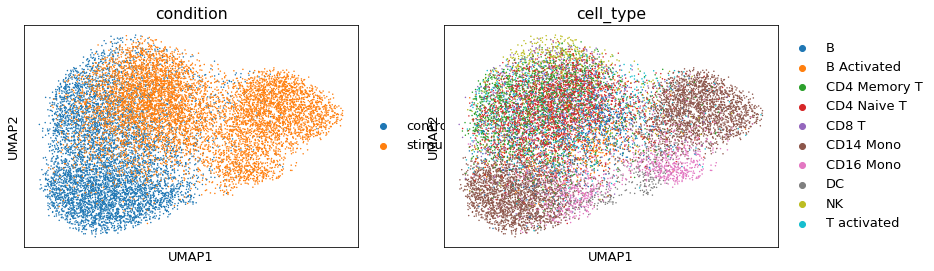

In [126]:
sc.pl.umap(adata, color=['condition', 'cell_type'])

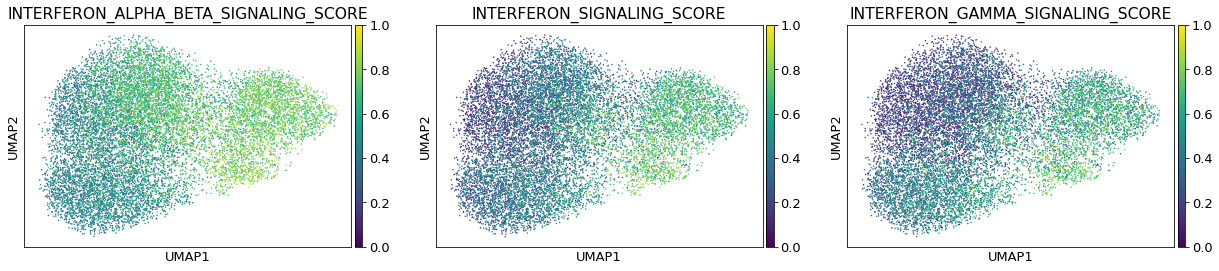

In [127]:
sc.pl.umap(adata, color=['INTERFERON_ALPHA_BETA_SIGNALING_SCORE' , 'INTERFERON_SIGNALING_SCORE', 'INTERFERON_GAMMA_SIGNALING_SCORE'])

In [128]:
adata.obsm['gene_sets_embeddings'] = autoencoder.compute_gene_sets_embeddings_(data.scores).detach().numpy()

In [129]:
sc.pp.neighbors(adata, use_rep='gene_sets_embeddings')
sc.tl.umap(adata)

### plot gene sets embeddings multiplied by scores

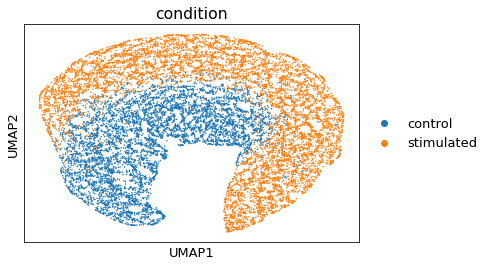

In [130]:
sc.pl.umap(adata, color='condition')

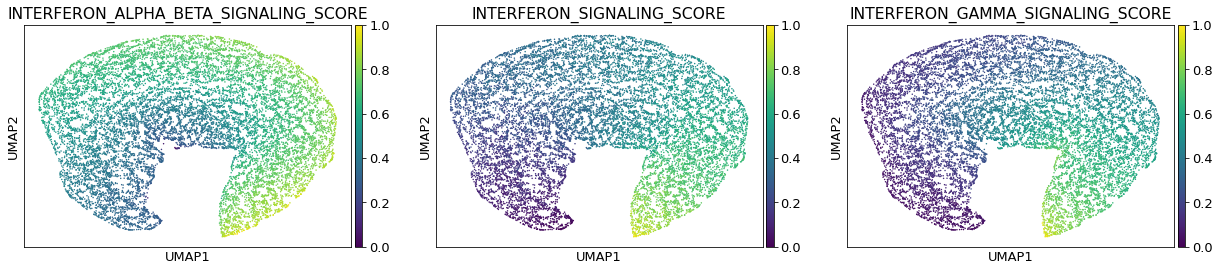

In [131]:
sc.pl.umap(adata, color=['INTERFERON_ALPHA_BETA_SIGNALING_SCORE' , 'INTERFERON_SIGNALING_SCORE', 'INTERFERON_GAMMA_SIGNALING_SCORE'])

In [132]:
adata.obsm['latent'] = adata.obsm['latent_basal'] + adata.obsm['gene_sets_embeddings']

In [133]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)

### plot full latent vectors (basal+scores*embeddings)

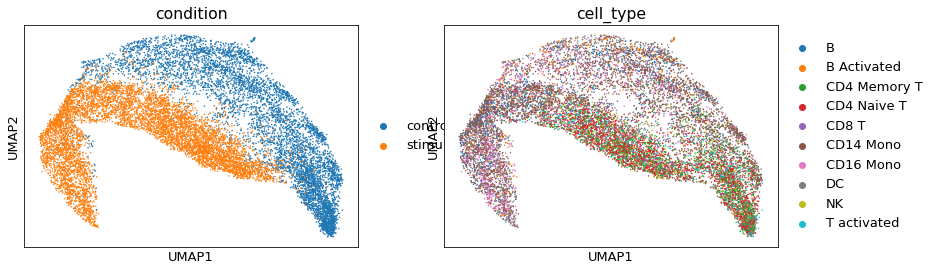

In [134]:
sc.pl.umap(adata, color=['condition', 'cell_type'])

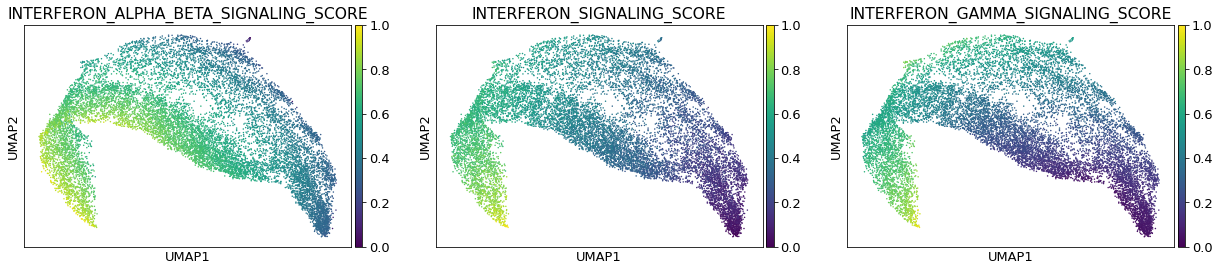

In [135]:
sc.pl.umap(adata, color=['INTERFERON_ALPHA_BETA_SIGNALING_SCORE' , 'INTERFERON_SIGNALING_SCORE', 'INTERFERON_GAMMA_SIGNALING_SCORE'])

### what happens if we increase the score on interferon alpha beta signalling for control

In [136]:
scores = adata.obsm['scores_tr'].copy()

In [137]:
scores[adata.obs.condition=='control', 0] += 0.15

In [138]:
scores = torch.Tensor(np.minimum(scores, 1.))

In [139]:
adata.obsm['latent_score_+0.15'] = adata.obsm['latent_basal'] + autoencoder.compute_gene_sets_embeddings_(scores).detach().numpy()

In [140]:
sc.pp.neighbors(adata, use_rep='latent_score_+0.15')
sc.tl.umap(adata)

### interferon alpha beta signalling for control + 0.15 

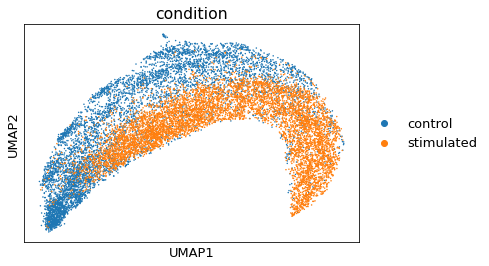

In [141]:
sc.pl.umap(adata, color='condition')

In [142]:
scores = adata.obsm['scores_tr'].copy()

In [143]:
scores[adata.obs.condition=='control', 0] += 0.3

In [144]:
scores = torch.Tensor(np.minimum(scores, 1.))

In [145]:
adata.obsm['latent_score_+0.3'] = adata.obsm['latent_basal'] + autoencoder.compute_gene_sets_embeddings_(scores).detach().numpy()

In [146]:
sc.pp.neighbors(adata, use_rep='latent_score_+0.3')
sc.tl.umap(adata)

### interferon alpha beta signalling for control + 0.3

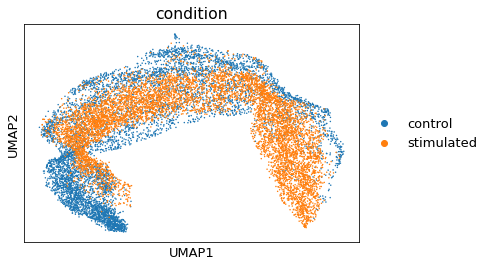

In [147]:
sc.pl.umap(adata, color='condition')

### bad disentanglement

In [149]:
adv_scores = autoencoder.adversary_gene_sets(latents).detach().sigmoid().numpy()

In [151]:
from scipy.stats import pearsonr

In [154]:
for i in range(3):
    print(pearsonr(adv_scores[:, i], adata.obsm['scores_tr'][:, i]))

(0.9526830226614298, 0.0)
(0.9649463295563017, 0.0)
(0.9666050274589711, 0.0)


In [159]:
adata.obs['INTERFERON_ALPHA_BETA_SIGNALING_ADV_PRED_SCORE'] = adv_scores[:, 0]

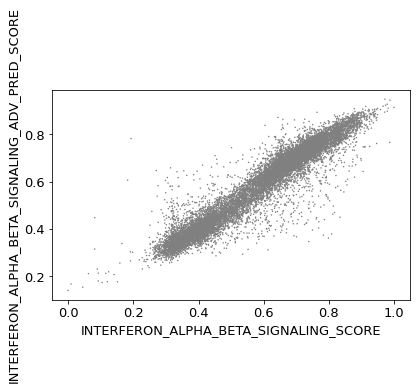

In [164]:
sc.pl.scatter(adata, x='INTERFERON_ALPHA_BETA_SIGNALING_SCORE', y='INTERFERON_ALPHA_BETA_SIGNALING_ADV_PRED_SCORE')